# Homework 1
Stephanie Sarette

#### About
For this project, I am going to study cyanobacteria algae blooms in 5 reservoirs. These reservoirs are Buckhorn Lake, Barren River Lake, C.J. Brown Lake, Nolin Lake, and West Fork Lake. These vary in the type of lake: Forest, Agriculture, or Urban, and stratification level: strong, weak, or none. Questions this study will answer:
1. Does stratification level for lakes impact the number of algae blooms seen each year?
2. Does stratification level for lakes impact the strength of the algae blooms?
3. Does the type of lake impact the number of algea blooms seen each year?
4. Does the type of lake impact the strength of the algae blooms seen each year?
5. Has precipitation levels at the local level changed over time?
6. Does the amount of precipitation impact algae blooms?
7. Has the temperatture at the local level changed over time?
8. Does the temperature impact algae blooms?
9. Is there a correlation between air temperature and surface temperature?
10. Is there a correlation between air temperature and deep water temperatures?
11. Do any of these factors affect the dissolved oxygen levels in the lakes?

## Part 1: Data Collection and Cleaning 

In [463]:
import requests
import pandas as pd
from datetime import datetime
import time

### API Weather Data - 1990
(note: latitude=37.3386, longitude=-83.4707)

In [900]:
# read in csv file on reservoir information
# we need this for the latitude and longitude part of the api call
res = pd.read_excel('Reservoir_information.xlsx', 1)
res.head()

,Reservoir abbreviation,Reservoir,Type,Stratification,Year,Latitude,Longitude,Watershed,Forest,Surface,Storage volume,Max depth,Mean depth,Zmean:Zmax
0,NaN,Name,NaN,NaN,filled,decimal,decimal,area km2,% (0-1),area km2,106 m3,meters,meters,NaN
1,BHR,Buckhorn Lake,Forest,Strong,1961,37.3386,-83.4707,1072,0.843,5,1.6,16.7,1.4,0.0838
2,BRR,Barren River Lake,Ag,Strong,1964,36.892,-86.1225,1500,0.385,39,15.4,16.7,2.2,0.1317
3,BVR,Brookville Lake,Ag,Strong,1974,39.4428,-85.0001,1031,0.225,21,33.8,31.9,8.8,0.2759
4,CBR,C. J. Brown Lake,Ag,NaN,1975,39.9485,-83.7459,225,0.087,8,7.2,10.3,4.8,0.4660


In [901]:
res = res.drop(index = 0).reset_index(drop=True) # drops the first row 
res.columns = res.columns.str.lower() # make column names lower case
# rename the column headers to replace a space with an underscore
res.rename(columns={'reservoir abbreviation': 'reservoir_abbreviation', 'storage volume': 'storage_volume',
                  'max depth': 'max_depth', 'mean depth': 'mean_depth'}, inplace=True)
# select desired reservoirs
res = res[(res['reservoir_abbreviation'] == 'BHR') | (res['reservoir_abbreviation'] == 'BRR') | (res['reservoir_abbreviation'] == 'CBR') | (res['reservoir_abbreviation'] == 'NRR') | (res['reservoir_abbreviation'] == 'WFR')]
res = res.reset_index(drop = True) # reset index
res

,reservoir_abbreviation,reservoir,type,stratification,year,latitude,longitude,watershed,forest,surface,storage_volume,max_depth,mean_depth,zmean:zmax
0,BHR,Buckhorn Lake,Forest,Strong,1961,37.3386,-83.4707,1072,0.843,5,1.6,16.7,1.4,0.0838
1,BRR,Barren River Lake,Ag,Strong,1964,36.892,-86.1225,1500,0.385,39,15.4,16.7,2.2,0.1317
2,CBR,C. J. Brown Lake,Ag,NaN,1975,39.9485,-83.7459,225,0.087,8,7.2,10.3,4.8,0.4660
3,NRR,Nolin Lake,Ag,Weak,1964,37.2792,-86.2469,1582,0.456,23,14.9,24,3.8,0.1583
4,WFR,West Fork Lake,Urban,NaN,1953,39.2607,-84.4975,98,0.007,1,0.4,3.6,2.6,0.7429


In [902]:
res.isnull().sum()

reservoir_abbreviation    0
reservoir                 0
type                      0
stratification            2
year                      0
latitude                  0
longitude                 0
watershed                 0
forest                    0
surface                   0
storage_volume            0
max_depth                 0
mean_depth                0
zmean:zmax                0
dtype: int64

In [903]:
res = res.fillna('None')
res

,reservoir_abbreviation,reservoir,type,stratification,year,latitude,longitude,watershed,forest,surface,storage_volume,max_depth,mean_depth,zmean:zmax
0,BHR,Buckhorn Lake,Forest,Strong,1961,37.3386,-83.4707,1072,0.843,5,1.6,16.7,1.4,0.0838
1,BRR,Barren River Lake,Ag,Strong,1964,36.8920,-86.1225,1500,0.385,39,15.4,16.7,2.2,0.1317
2,CBR,C. J. Brown Lake,Ag,None,1975,39.9485,-83.7459,225,0.087,8,7.2,10.3,4.8,0.4660
3,NRR,Nolin Lake,Ag,Weak,1964,37.2792,-86.2469,1582,0.456,23,14.9,24.0,3.8,0.1583
4,WFR,West Fork Lake,Urban,None,1953,39.2607,-84.4975,98,0.007,1,0.4,3.6,2.6,0.7429


In [477]:
# function to increase year for start and end date
def changeyear(date):
    year = date.split("-")[0]
    month = date.split("-")[1]
    day = date.split("-")[2]
    year = int(year) + 1
    year = str(year)
    return year + '-' + month + '-' + day
    

In [478]:
# create all variables for api calls and data collection
start_date = "1987-01-01" # start date for collecting data
end_date = "1987-12-31" # end date for data collecting
final_date = "2022-01-01" # the final date for data collection
date = [] # empty list to store date
daily_temps = [] # empty list to store avg daily temp
daylight_duration = [] # empty list to store daylight duration
precipitation_sum = [] # empty list to store daily total precipitation
lat = res['latitude'] # create a list of latitudes
long = res['longitude'] # create a list of longitudes
abbr = res['reservoir_abbreviation'] # create list of reservoir abbreviations
latitude = [] # empty string to store latitudes
longitude = [] # empty string to store longitudes
abbreviation = [] # empty string to store reservoir abbreviations

In [479]:
# loop to call API data from 1987-2021 for each selected reservoir
for i in range(len(lat)):
    while start_date != final_date:
        url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat[i]}&longitude={long[i]}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_mean,daylight_duration,precipitation_sum&timezone=America%2FChicago" 
        response = requests.get(url)
        if response.status_code == 200:
            print('yes!')
            # get json data
            data = response.json()
            # store the date
            day = data['daily']['time']
            date.extend(day)
            # store the temp
            temp = data['daily']['temperature_2m_mean']
            daily_temps.extend(temp)
            # store the daylight duration
            daylight = data['daily']['daylight_duration']
            daylight_duration.extend(daylight)
            # store the precipitation sum
            precip = data['daily']['precipitation_sum']
            precipitation_sum.extend(precip)
            # store the latitude
            l1 = [lat[i]] * len(day)
            latitude.extend(l1)
            # store the longitude
            l2 = [long[i]] * len(day)
            longitude.extend(l2)
            # store the reservoir abbreviation
            a = [abbr[i]] * len(day)
            abbreviation.extend(a)
        else:
            print(f"Error: {response}")
        start_date = changeyear(start_date)
        end_date = changeyear(end_date)
    start_date = "1987-01-01"
    end_date = "1987-12-31"
    time.sleep(10)

yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!


In [570]:
# Create data frame
api = pd.DataFrame({'reservoir':abbreviation, 'latitude':latitude, 'longitude':longitude, 'date':date, 'temperature':daily_temps, 
                    'daylight_duration':daylight_duration, 'precipitation_sum':precipitation_sum})
api['year'] = api.date.str.split("-").str.get(0)
api['month'] = api.date.str.split("-").str.get(1)
api['day'] = api.date.str.split("-").str.get(2)
api['yearmonth'] = api['year']+api['month']
api.head()

,reservoir,latitude,longitude,date,temperature,daylight_duration,precipitation_sum,year,month,day,yearmonth
0,BHR,37.3386,-83.4707,1987-01-01,2.2,34702.07,1.2,1987,01,01,198701
1,BHR,37.3386,-83.4707,1987-01-02,0.7,34740.15,1.3,1987,01,02,198701
2,BHR,37.3386,-83.4707,1987-01-03,0.4,34781.37,0.0,1987,01,03,198701
3,BHR,37.3386,-83.4707,1987-01-04,0.3,34825.67,0.0,1987,01,04,198701
4,BHR,37.3386,-83.4707,1987-01-05,1.2,34873.01,0.0,1987,01,05,198701


In [571]:
# export api weather data to csv
api.to_csv('weather_api_data.csv')

### Reservoir Surface Temp

In [888]:
# import surface temperature csv file
surfaceTemp = pd.read_excel('Surface_Temperatures_standardized_FINAL.xlsx', "All_reservoirs")
surfaceTemp.head()

,Reservoir,Date,month,day,year,MonthYear,DateEXC,temperature,Depth (ft),Predicted,...,month.5,day.5,year.5,MonthYear.5,DateEXC.5,temperature.5,Depth (ft).5,Predicted.5,Residual.5,15.5th.5
0,BHR,19890502.0,5.0,2.0,1989.0,51989.0,1989-05-02 00:00:00,18.7,0.0,18.3702,...,10.0,3.0,1989.0,101989.0,1989-10-03 00:00:00,19.9,0.0,22.0592,-2.1592,17.4425
1,BHR,19890502.0,5.0,2.0,1989.0,51989.0,1989-05-02 00:00:00,18.9,5.0,18.3702,...,10.0,3.0,1989.0,101989.0,1989-10-03 00:00:00,20.2,5.0,22.0592,-1.8592,17.7425
2,BHR,19890509.0,5.0,9.0,1989.0,51989.0,1989-05-09 00:00:00,15.7,0.0,19.6379,...,10.0,10.0,1989.0,101989.0,1989-10-10 00:00:00,16.2,0.0,20.6830,-4.4830,15.1187
3,BHR,19890509.0,5.0,9.0,1989.0,51989.0,1989-05-09 00:00:00,15.6,5.0,19.6379,...,10.0,10.0,1989.0,101989.0,1989-10-10 00:00:00,16.5,5.0,20.6830,-4.1830,15.4187
4,BHR,19890516.0,5.0,16.0,1989.0,51989.0,1989-05-16 00:00:00,16.4,0.0,20.9056,...,10.0,23.0,1989.0,101989.0,1989-10-23 00:00:00,16.5,0.0,18.1272,-1.6272,17.9745


In [889]:
surfaceTemp.columns # check column names

Index(['Reservoir', 'Date', 'month', 'day', 'year', 'MonthYear', 'DateEXC',
       'temperature', 'Depth (ft)', 'Predicted', 'Residual', '15.5th',
       'Unnamed: 12', 'Reservoir.1', 'Date.1', 'month.1', 'day.1', 'year.1',
       'MonthYear.1', 'DateEXC.1', 'temperature.1', 'Depth (ft).1',
       'Predicted.1', 'Residual.1', '15.5th.1', 'Unnamed: 25', 'Reservoir.2',
       'Date.2', 'month.2', 'day.2', 'year.2', 'MonthYear.2', 'DateEXC.2',
       'temperature.2', 'Depth (ft).2', 'Predicted.2', 'Residual.2',
       '15.5th.2', 'Unnamed: 38', 'Reservoir.3', 'Date.3', 'month.3', 'day.3',
       'year.3', 'MonthYear.3', 'DateEXC.3', 'temperature.3', 'Depth (ft).3',
       'Predicted.3', 'Residual.3', '15.5th.3', 'Unnamed: 51', 'Reservoir.4',
       'Date.4', 'month.4', 'day.4', 'year.4', 'MonthYear.4', 'DateEXC.4',
       'temperature.4', 'Depth (ft).4', 'Predicted.4', 'Residual.4',
       '15.5th.4', 'Unnamed: 64', 'Reservoir.5', 'Date.5', 'month.5', 'day.5',
       'year.5', 'MonthYear.

In [890]:
# There are 6 columns for each feature in this data frame
# I need to figure out how to combine them so that reservoir, reservoir.1, reservoir.2, etc are in one column
# I think I will create 5 data frames from this one, then combine them correctly
# I am also going to drop the predicted, residual, and 15.5th columns since I don't need them

# create data frame for first set of columns
df1 = surfaceTemp[['Reservoir', 'Date', 'month', 'day', 'year', 'MonthYear', 'DateEXC',
       'temperature', 'Depth (ft)']]
df1.isnull().sum() # check null values
df1 = df1.dropna() # remove all rows with null values since no data is recorded in these rows
df1.isnull().sum() # check null values again
# rename depth column
df1 = df1.rename(columns = {'Depth (ft)':'depth_ft'})


In [891]:
# create dataframe for second set of columns
df2 = surfaceTemp[['Reservoir.1', 'Date.1', 'month.1', 'day.1', 'year.1','MonthYear.1', 'DateEXC.1', 
                   'temperature.1', 'Depth (ft).1']]
df2.isnull().sum() # check null values
df2 = df2.dropna() # remove all rows with null values since no data is recorded in these rows
df2.isnull().sum() # check null values again
# rename columns so they match the columns for df1
df2 = df2.rename(columns = {'Reservoir.1':'Reservoir', 'Date.1':'Date', 'month.1':'month', 'day.1':'day', 'year.1':'year','MonthYear.1':'MonthYear', 
                  'DateEXC.1':'DateEXC', 'temperature.1':'temperature', 'Depth (ft).1':'depth_ft'})


In [892]:
# create dataframe for third set of columns
df3 = surfaceTemp[['Reservoir.2','Date.2', 'month.2', 'day.2', 'year.2', 'MonthYear.2', 'DateEXC.2',
       'temperature.2', 'Depth (ft).2']]
df3.isnull().sum() # check null values
df3 = df3.dropna() # remove all rows with null values since no data is recorded in these rows
df3.isnull().sum() # check null values again
# rename columns so they match the columns for df1
df3 = df3.rename(columns = {'Reservoir.2':'Reservoir', 'Date.2':'Date', 'month.2':'month', 'day.2':'day', 'year.2':'year','MonthYear.2':'MonthYear', 
                  'DateEXC.2':'DateEXC', 'temperature.2':'temperature', 'Depth (ft).2':'depth_ft'})


In [893]:
# create dataframe for fourth set of columns
df4 = surfaceTemp[['Reservoir.3', 'Date.3', 'month.3', 'day.3','year.3', 'MonthYear.3', 'DateEXC.3', 
                   'temperature.3', 'Depth (ft).3']]
df4.isnull().sum() # check null values, there are none. 
# rename columns so they match the columns for df1
df4 = df4.rename(columns = {'Reservoir.3':'Reservoir', 'Date.3':'Date', 'month.3':'month', 'day.3':'day', 'year.3':'year','MonthYear.3':'MonthYear', 
                  'DateEXC.3':'DateEXC', 'temperature.3':'temperature', 'Depth (ft).3':'depth_ft'})


In [894]:
# create dataframe for fifth set of columns
df5 = surfaceTemp[['Reservoir.4','Date.4', 'month.4', 'day.4', 'year.4', 'MonthYear.4', 'DateEXC.4',
       'temperature.4', 'Depth (ft).4']]
df5.isnull().sum() # check null values
df5 = df5.dropna() # remove all rows with null values since no data is recorded in these rows
df5.isnull().sum() # check null values again
# rename columns so they match the columns for df1
df5 = df5.rename(columns = {'Reservoir.4':'Reservoir', 'Date.4':'Date', 'month.4':'month', 'day.4':'day', 'year.4':'year','MonthYear.4':'MonthYear', 
                  'DateEXC.4':'DateEXC', 'temperature.4':'temperature', 'Depth (ft).4':'depth_ft'})


In [895]:
# create dataframe for sixth set of columns
df6 = surfaceTemp[['Reservoir.5','Date.5', 'month.5', 'day.5', 'year.5', 'MonthYear.5', 'DateEXC.5',
       'temperature.5', 'Depth (ft).5']]
df6.isnull().sum() # check null values
df6 = df6.dropna() # remove all rows with null values since no data is recorded in these rows
df6.isnull().sum() # check null values again
# rename columns so they match the columns for df1
df6 = df6.rename(columns = {'Reservoir.5':'Reservoir', 'Date.5':'Date', 'month.5':'month', 'day.5':'day', 'year.5':'year','MonthYear.5':'MonthYear', 
                  'DateEXC.5':'DateEXC', 'temperature.5':'temperature', 'Depth (ft).5':'depth_ft'})

In [897]:
# combine all the data frames by merging their columns
surfTemp = pd.concat([df1, df2, df3, df4, df5, df6])
# edit column names so they are all lower case
surfTemp.columns = surfTemp.columns.str.lower()
# remove dateexc column
surfTemp = surfTemp.drop(columns = ['dateexc'])

surfTemp.head()

,reservoir,date,month,day,year,monthyear,temperature,depth_ft
0,BHR,19890502.0,5.0,2.0,1989.0,51989.0,18.7,0.0
1,BHR,19890502.0,5.0,2.0,1989.0,51989.0,18.9,5.0
2,BHR,19890509.0,5.0,9.0,1989.0,51989.0,15.7,0.0
3,BHR,19890509.0,5.0,9.0,1989.0,51989.0,15.6,5.0
4,BHR,19890516.0,5.0,16.0,1989.0,51989.0,16.4,0.0


In [583]:
surfTemp.dtypes

reservoir       object
date           float64
month          float64
day            float64
year           float64
monthyear      float64
temperature    float64
depth_ft       float64
dtype: object

In [584]:
# change day, month, year, and monthyear to int
surfTemp['month'] = surfTemp['month'].astype('int64')
surfTemp['day'] = surfTemp['day'].astype('int64')
surfTemp['year'] = surfTemp['year'].astype('int64')
surfTemp['monthyear'] = surfTemp['monthyear'].astype('int64')
surfTemp['date'] = surfTemp['date'].astype('int64')

# change day, month, year, and monthyear to objects
surfTemp['year'] = surfTemp['year'].astype('str')
surfTemp['monthyear'] = surfTemp['monthyear'].astype('object')
surfTemp['date'] = surfTemp['date'].astype('str')

In [585]:
surfTemp.dtypes

reservoir       object
date            object
month            int64
day              int64
year            object
monthyear       object
temperature    float64
depth_ft       float64
dtype: object

In [586]:
# create a function to convert int to string for days and months
def to_string(num_list):
    num_str = []
    for i in range(len(num_list)):
        if num_list[i] <= 9:
            n = ['0' + str(num_list[i])]
            num_str.extend(n)
        else:
            num_str.extend([str(num_list[i])])
    return num_str

In [587]:
# convert the list of day and month to include 0s for single digits
day = list(surfTemp['day'])
month = list(surfTemp['month'])

day_str = to_string(day)
month_str = to_string(month)

surfTemp['day'] = day_str
surfTemp['month'] = month_str

In [588]:
surfTemp['date'] = surfTemp['year']+surfTemp['month']+surfTemp['day'] # fix the date so all values are in a consistent order
surfTemp['date'] = pd.to_datetime(surfTemp['date'], format='%Y%m%d') # add dashes to date so it is easier to read
surfTemp['yearmonth'] = surfTemp['year'] + surfTemp['month'] # fix month year to include 0 for single digit months
surfTemp = surfTemp.drop(columns = {'monthyear'})
surfTemp.head() # surface temp data is clean

,reservoir,date,month,day,year,temperature,depth_ft,yearmonth
0,BHR,1989-05-02,05,02,1989,18.7,0.0,198905
1,BHR,1989-05-02,05,02,1989,18.9,5.0,198905
2,BHR,1989-05-09,05,09,1989,15.7,0.0,198905
3,BHR,1989-05-09,05,09,1989,15.6,5.0,198905
4,BHR,1989-05-16,05,16,1989,16.4,0.0,198905


In [589]:
# check null values
surfTemp.isnull().sum()

reservoir      0
date           0
month          0
day            0
year           0
temperature    0
depth_ft       0
yearmonth      0
dtype: int64

In [590]:
surfTemp.to_csv('clean_surface_temp_data.csv')

### Reservoir Deep Water Temperature

In [591]:
# import deep temperature file
deepTemp = pd.read_excel('Deep_Temperatures_standardized_FINAL.xlsx', 'Data_5_ft_intervals')
deepTemp.head()

,Reservoir,Date,Month,day,Year,MonthYear,DateEXC,Temperature (Celsius),Depth (ft)
0,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,16.9,20
1,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,15.9,25
2,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,15.8,30
3,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,13.9,35
4,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,13.2,40


In [592]:
# delete DateEXC column and make all other columns lowercase
deepTemp = deepTemp.drop(columns = ['DateEXC'])
deepTemp.columns = deepTemp.columns.str.lower()

In [593]:
# rename temperature and depth columns
deepTemp = deepTemp.rename(columns = {'temperature (celsius)':'temperature', 'depth (ft)':'depth_ft'})
deepTemp.dtypes # check data types

reservoir       object
date             int64
month            int64
day              int64
year             int64
monthyear        int64
temperature    float64
depth_ft         int64
dtype: object

In [594]:
# edit date, month, day, year, and monthyear columns to include 0s for single digit days and months
deepTemp['year'] = deepTemp['year'].astype('str')
day = list(deepTemp['day'])
month = list(deepTemp['month'])

day_str = to_string(day)
month_str = to_string(month)

deepTemp['day'] = day_str
deepTemp['month'] = month_str

deepTemp['yearmonth'] = deepTemp['year'] + deepTemp['month']
deepTemp['date'] = deepTemp['year'] + deepTemp['month'] + deepTemp['day']
deepTemp['date'] = pd.to_datetime(deepTemp['date'], format='%Y%m%d')
deepTemp = deepTemp.drop(columns = {'monthyear'})

deepTemp.head()

,reservoir,date,month,day,year,temperature,depth_ft,yearmonth
0,BHR,1989-05-02,05,02,1989,16.9,20,198905
1,BHR,1989-05-02,05,02,1989,15.9,25,198905
2,BHR,1989-05-02,05,02,1989,15.8,30,198905
3,BHR,1989-05-02,05,02,1989,13.9,35,198905
4,BHR,1989-05-02,05,02,1989,13.2,40,198905


In [595]:
# check null values
deepTemp.isnull().sum()

reservoir      0
date           0
month          0
day            0
year           0
temperature    0
depth_ft       0
yearmonth      0
dtype: int64

In [596]:
# export to csv
deepTemp.to_csv('clean_deep_temp_data.csv')

### Reservoir Dissolved Oxygen Deep

In [785]:
# import file on dissolved oxygen
do = pd.read_excel('Deep_DO_standardized_FINAL.xlsx', 'All>20ft_depth_5ft_intervals')
do.head()

,Reservoir,Date,month,day,year,monthyear,dateEXC,DO,depth
0,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,8.6,20
1,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,8.7,25
2,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,9.0,30
3,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,9.0,35
4,BHR,19890502,5,2,1989,51989,1989-05-02 00:00:00,9.0,40


In [786]:
# delete dateEXC column and make all other columns lowercase
do = do.drop(columns = ['dateEXC'])
do.columns = do.columns.str.lower()

In [787]:
# rename depth column
do = do.rename(columns = {'depth':'depth_ft'})
do.dtypes # check data types

reservoir     object
date           int64
month          int64
day            int64
year           int64
monthyear      int64
do           float64
depth_ft       int64
dtype: object

In [788]:
# edit date, month, day, year, and monthyear columns to include 0s for single digit days and months
do['year'] = do['year'].astype('str')
day = list(do['day'].astype('int64'))
month = list(do['month'].astype('int64'))

day_str = to_string(day)
month_str = to_string(month)

do['day'] = day_str
do['month'] = month_str

do['yearmonth'] = do['year'] + do['month']
do['date'] = do['year'] + do['month'] + do['day']
do['date'] = pd.to_datetime(do['date'], format='%Y%m%d')
do = do.drop(columns = {'monthyear'})

do.head()

,reservoir,date,month,day,year,do,depth_ft,yearmonth
0,BHR,1989-05-02,05,02,1989,8.6,20,198905
1,BHR,1989-05-02,05,02,1989,8.7,25,198905
2,BHR,1989-05-02,05,02,1989,9.0,30,198905
3,BHR,1989-05-02,05,02,1989,9.0,35,198905
4,BHR,1989-05-02,05,02,1989,9.0,40,198905


In [789]:
# check null values
do.isnull().sum()

reservoir    0
date         0
month        0
day          0
year         0
do           0
depth_ft     0
yearmonth    0
dtype: int64

In [790]:
# export to csv
do.to_csv('clean_DO_data.csv')

### Reservoir Cyanotaxa data

In [791]:
# read file on cyanobacteria blooms 
algae = pd.read_excel('Cyanotoxin_taxa_data.xlsx', 'All_data')
algae.head()

,SampleID,reservoir,station,year,month,day,date,depth,density_cells/ml,toxin,sci_name,FinalTaxaType,TaxaType,Empire,Kingdom,PhylumDivision,Class,Order
0,BHR20001198807191200000,BHR,20001,1988,7,19,7/19/1988,0,211.527808,1,ANABAENA,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Nostocales
1,BHR20001198807191200000,BHR,20001,1988,7,19,7/19/1988,0,24.088576,0,SCHIZOTHRIX,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Pseudanabaenales
2,BHR20001198807191200005,BHR,20001,1988,7,19,7/19/1988,5,0.926524,1,CHROOCOCCUS,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Chroococcales
3,BHR20001198807191200005,BHR,20001,1988,7,19,7/19/1988,5,125.544002,1,ANABAENA,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Nostocales
4,BHR20001198807191200005,BHR,20001,1988,7,19,7/19/1988,5,12.508074,0,SCHIZOTHRIX,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Pseudanabaenales


In [792]:
# lowercase the column names
algae.columns = algae.columns.str.lower()

In [793]:
algae.dtypes # check data types

sampleid             object
reservoir            object
station               int64
year                  int64
month                 int64
day                   int64
date                 object
depth                 int64
density_cells/ml    float64
toxin                 int64
sci_name             object
finaltaxatype        object
taxatype             object
empire               object
kingdom              object
phylumdivision       object
class                object
order                object
dtype: object

In [794]:
# edit date, month, day, year, and monthyear columns to include 0s for single digit days and months
algae['year'] = algae['year'].astype('str')
day = list(algae['day'])
month = list(algae['month'])

day_str = to_string(day)
month_str = to_string(month)

algae['day'] = day_str
algae['month'] = month_str

algae['date'] = algae['year'] + algae['month'] + algae['day']
algae['date'] = pd.to_datetime(algae['date'], format='%Y%m%d')
algae['yearmonth'] = algae['year'] + algae['month']

algae.head()

,sampleid,reservoir,station,year,month,day,date,depth,density_cells/ml,toxin,sci_name,finaltaxatype,taxatype,empire,kingdom,phylumdivision,class,order,yearmonth
0,BHR20001198807191200000,BHR,20001,1988,07,19,1988-07-19,0,211.527808,1,ANABAENA,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Nostocales,198807
1,BHR20001198807191200000,BHR,20001,1988,07,19,1988-07-19,0,24.088576,0,SCHIZOTHRIX,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Pseudanabaenales,198807
2,BHR20001198807191200005,BHR,20001,1988,07,19,1988-07-19,5,0.926524,1,CHROOCOCCUS,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Chroococcales,198807
3,BHR20001198807191200005,BHR,20001,1988,07,19,1988-07-19,5,125.544002,1,ANABAENA,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Nostocales,198807
4,BHR20001198807191200005,BHR,20001,1988,07,19,1988-07-19,5,12.508074,0,SCHIZOTHRIX,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Pseudanabaenales,198807


In [795]:
algae.isnull().sum() # check null values

sampleid               0
reservoir              0
station                0
year                   0
month                  0
day                    0
date                   0
depth                  0
density_cells/ml       0
toxin                  0
sci_name               0
finaltaxatype          0
taxatype               0
empire              1276
kingdom             1980
phylumdivision      1980
class               1980
order               1980
yearmonth              0
dtype: int64

In [796]:
# fill null values with unknown since I don't know how to tell what the missing values are
algae = algae.fillna('Unkown')
algae.isnull().sum()

sampleid            0
reservoir           0
station             0
year                0
month               0
day                 0
date                0
depth               0
density_cells/ml    0
toxin               0
sci_name            0
finaltaxatype       0
taxatype            0
empire              0
kingdom             0
phylumdivision      0
class               0
order               0
yearmonth           0
dtype: int64

In [904]:
algae.head()

,sampleid,reservoir,station,year,month,day,date,depth,density_cells/ml,toxin,sci_name,finaltaxatype,taxatype,empire,kingdom,phylumdivision,class,order,yearmonth
0,BHR20001198807191200000,BHR,20001,1988,07,19,1988-07-19,0,211.527808,1,ANABAENA,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Nostocales,198807
1,BHR20001198807191200000,BHR,20001,1988,07,19,1988-07-19,0,24.088576,0,SCHIZOTHRIX,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Pseudanabaenales,198807
2,BHR20001198807191200005,BHR,20001,1988,07,19,1988-07-19,5,0.926524,1,CHROOCOCCUS,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Chroococcales,198807
3,BHR20001198807191200005,BHR,20001,1988,07,19,1988-07-19,5,125.544002,1,ANABAENA,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Nostocales,198807
4,BHR20001198807191200005,BHR,20001,1988,07,19,1988-07-19,5,12.508074,0,SCHIZOTHRIX,Cyanobacteria,Blue-Green Algae,Prokaryota,Eubacteria,Cyanobacteria,Cyanophyceae,Pseudanabaenales,198807


In [797]:
# export to csv
algae.to_csv('clean_HAB_data.csv')

## Part 2: Data Visualizations

In [622]:
import matplotlib.pyplot as plt
import numpy as np

In [614]:
api.columns

Index(['reservoir', 'latitude', 'longitude', 'date', 'temperature',
       'daylight_duration', 'precipitation_sum', 'year', 'month', 'day',
       'yearmonth'],
      dtype='object')

In [615]:
surfTemp.columns

Index(['reservoir', 'date', 'month', 'day', 'year', 'temperature', 'depth_ft',
       'yearmonth'],
      dtype='object')

In [616]:
deepTemp.columns

Index(['reservoir', 'date', 'month', 'day', 'year', 'temperature', 'depth_ft',
       'yearmonth'],
      dtype='object')

In [617]:
do.columns

Index(['reservoir', 'date', 'month', 'day', 'year', 'do', 'depth_ft',
       'yearmonth'],
      dtype='object')

In [618]:
algae.columns

Index(['SampleID', 'reservoir', 'station', 'year', 'month', 'day', 'date',
       'depth', 'density_cells/ml', 'toxin', 'sci_name', 'FinalTaxaType',
       'TaxaType', 'Empire', 'Kingdom', 'PhylumDivision', 'Class', 'Order',
       'yearmonth'],
      dtype='object')

In [619]:
res.columns

Index(['reservoir_abbreviation', 'reservoir', 'type', 'stratification', 'year',
       'latitude', 'longitude', 'watershed', 'forest', 'surface',
       'storage_volume', 'max_depth', 'mean_depth', 'zmean:zmax'],
      dtype='object')

#### Figure 1: Change in Air Temp Over time

In [921]:
# group by reservoir and year by taking the average temperature
avg_temp = api.groupby(['reservoir', 'year'])['temperature'].mean()

In [922]:
# turn groupby into a data frame
avg_temp = pd.DataFrame(avg_temp).reset_index()
avg_temp['year'] = avg_temp['year'].astype('int64')
# split avg temps by reservoir
avgT_bhr = avg_temp[avg_temp['reservoir'] == 'BHR']
avgT_brr = avg_temp[avg_temp['reservoir'] == 'BRR']
avgT_cbr = avg_temp[avg_temp['reservoir'] == 'CBR']
avgT_nrr = avg_temp[avg_temp['reservoir'] == 'NRR']
avgT_wfr = avg_temp[avg_temp['reservoir'] == 'WFR']

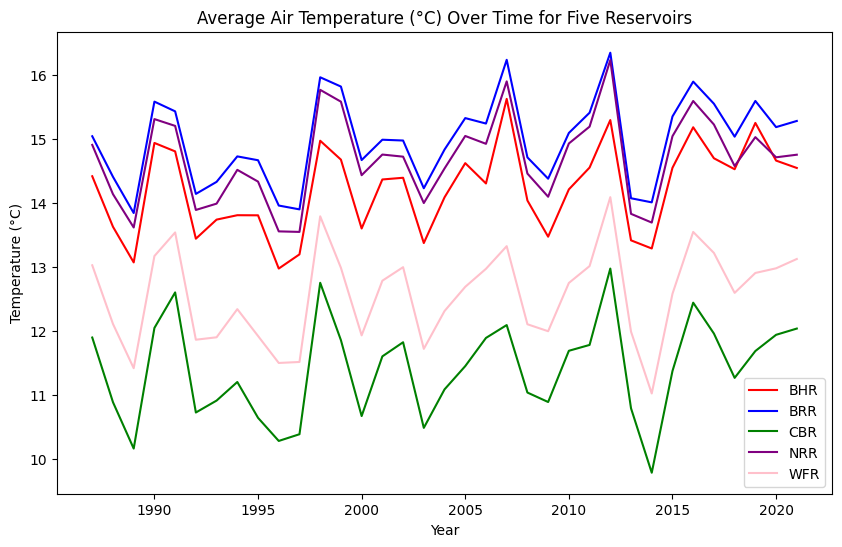

In [923]:
# create line plot for change in temperatures
plt.figure(figsize = (10, 6))
plt.plot(avgT_bhr['year'], avgT_bhr['temperature'], color = 'red', label = 'BHR')
plt.plot(avgT_brr['year'], avgT_brr['temperature'], color = 'blue', label = 'BRR')
plt.plot(avgT_cbr['year'], avgT_cbr['temperature'], color = 'green', label = 'CBR')
plt.plot(avgT_nrr['year'], avgT_nrr['temperature'], color = 'purple', label = 'NRR')
plt.plot(avgT_wfr['year'], avgT_wfr['temperature'], color = 'pink', label = 'WFR')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Air Temperature (°C) Over Time for Five Reservoirs');
plt.savefig('airtemp.png')

#### Figure 2: Change in Surface Temp Over Time

In [924]:
avg_surf = surfTemp.groupby(['reservoir', 'year'])['temperature'].mean()
avg_surf = pd.DataFrame(avg_surf).reset_index()
avg_surf['year'] = avg_surf['year'].astype('int64')
# split avg temps by reservoir
avgS_bhr = avg_surf[avg_surf['reservoir'] == 'BHR'].sort_values('year')
avgS_brr = avg_surf[avg_surf['reservoir'] == 'BRR'].sort_values('year')
avgS_cbr = avg_surf[avg_surf['reservoir'] == 'CBR'].sort_values('year')
avgS_nrr = avg_surf[avg_surf['reservoir'] == 'NRR'].sort_values('year')
avgS_wfr = avg_surf[avg_surf['reservoir'] == 'WFR'].sort_values('year')

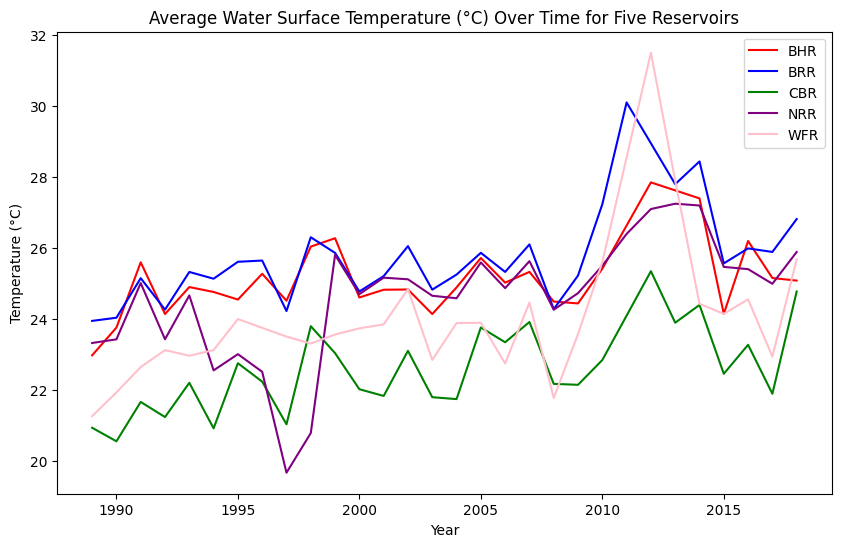

In [925]:
# create line plot for change in temperatures
plt.figure(figsize = (10, 6))
plt.plot(avgS_bhr['year'], avgS_bhr['temperature'], color = 'red', label = 'BHR')
plt.plot(avgS_brr['year'], avgS_brr['temperature'], color = 'blue', label = 'BRR')
plt.plot(avgS_cbr['year'], avgS_cbr['temperature'], color = 'green', label = 'CBR')
plt.plot(avgS_nrr['year'], avgS_nrr['temperature'], color = 'purple', label = 'NRR')
plt.plot(avgS_wfr['year'], avgS_wfr['temperature'], color = 'pink', label = 'WFR')
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Water Surface Temperature (°C) Over Time for Five Reservoirs');
plt.savefig('surftemp.png')

#### Figure 3: Change in Deep Water Temperature Over Time

In [926]:
# calculate the mean deep water temperature by year for each reservoir
avg_deep = deepTemp.groupby(['reservoir', 'year'])['temperature'].mean()
avg_deep = pd.DataFrame(avg_deep).reset_index()
avg_deep['year'] = avg_deep['year'].astype('int64')
# split avg temps by reservoir
avgD_bhr = avg_deep[avg_deep['reservoir'] == 'BHR'].sort_values('year')
avgD_brr = avg_deep[avg_deep['reservoir'] == 'BRR'].sort_values('year')
avgD_cbr = avg_deep[avg_deep['reservoir'] == 'CBR'].sort_values('year')
avgD_nrr = avg_deep[avg_deep['reservoir'] == 'NRR'].sort_values('year')
avgD_wfr = avg_deep[avg_deep['reservoir'] == 'WFR'].sort_values('year')

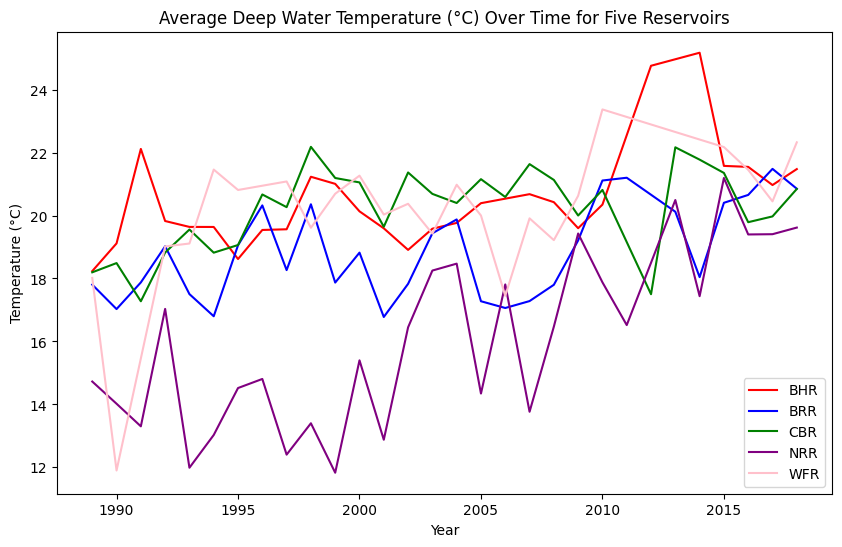

In [928]:
# create line plot for change in temperatures
plt.figure(figsize = (10,6))
plt.plot(avgD_bhr['year'], avgD_bhr['temperature'], color = 'red', label = 'BHR')
plt.plot(avgD_brr['year'], avgD_brr['temperature'], color = 'blue', label = 'BRR')
plt.plot(avgD_cbr['year'], avgD_cbr['temperature'], color = 'green', label = 'CBR')
plt.plot(avgD_nrr['year'], avgD_nrr['temperature'], color = 'purple', label = 'NRR')
plt.plot(avgD_wfr['year'], avgD_wfr['temperature'], color = 'pink', label = 'WFR')
plt.legend(loc='lower right')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Deep Water Temperature (°C) Over Time for Five Reservoirs');
plt.savefig('deeptemp.png')

#### Figure 4: Change in Dissolved Oxygen Over Time for 5 reservoirs of interest

In [934]:
# calculate the mean deep water do by year for each reservoir
avg_do = do.groupby(['reservoir', 'year'])['do'].mean()
avg_do = pd.DataFrame(avg_do).reset_index()
avg_do['year'] = avg_do['year'].astype('int64')
# split avg do by reservoir
avgDO_bhr = avg_do[avg_do['reservoir'] == 'BHR'].sort_values('year')
avgDO_brr = avg_do[avg_do['reservoir'] == 'BRR'].sort_values('year')
avgDO_cbr = avg_do[avg_do['reservoir'] == 'CBR'].sort_values('year')
avgDO_nrr = avg_do[avg_do['reservoir'] == 'NRR'].sort_values('year')
avgDO_wfr = avg_do[avg_do['reservoir'] == 'WFR'].sort_values('year')

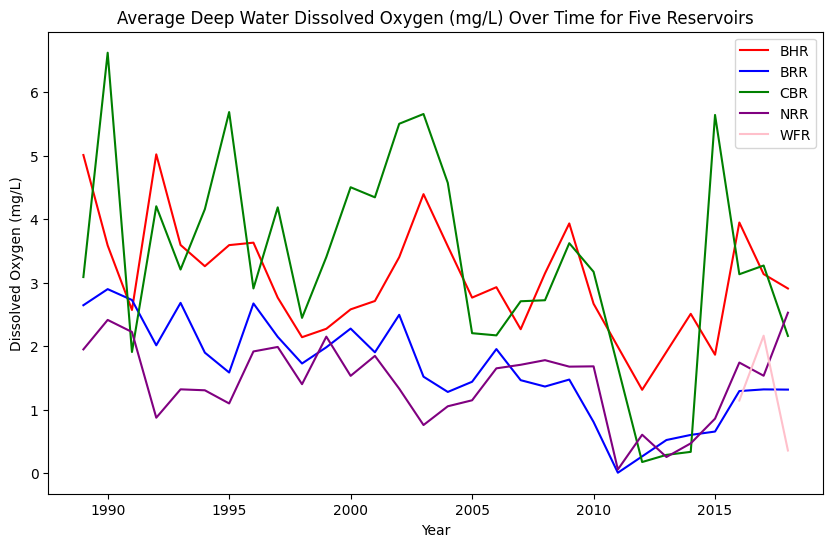

In [935]:
# create line plot for change in do over time
plt.figure(figsize = (10, 6))
plt.plot(avgDO_bhr['year'], avgDO_bhr['do'], color = 'red', label = 'BHR')
plt.plot(avgDO_brr['year'], avgDO_brr['do'], color = 'blue', label = 'BRR')
plt.plot(avgDO_cbr['year'], avgDO_cbr['do'], color = 'green', label = 'CBR')
plt.plot(avgDO_nrr['year'], avgDO_nrr['do'], color = 'purple', label = 'NRR')
plt.plot(avgDO_wfr['year'], avgDO_wfr['do'], color = 'pink', label = 'WFR')
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.title('Average Deep Water Dissolved Oxygen (mg/L) Over Time for Five Reservoirs');
plt.savefig('dissolvedoxygen.png')

In figure 4, it apparent that dissolved oxygen data was not collected until 2016 for the West Fork Lake. 

#### Figure 5: Density of Algae Blooms in Each Lake

In [936]:
# pull out algae data for the five desired reservoirs
algae_bhr = algae[algae['reservoir'] == 'BHR']
algae_brr = algae[algae['reservoir'] == 'BRR']
algae_cbr = algae[algae['reservoir'] == 'CBR']
algae_nrr = algae[algae['reservoir'] == 'NRR']
algae_wfr = algae[algae['reservoir'] == 'WFR']

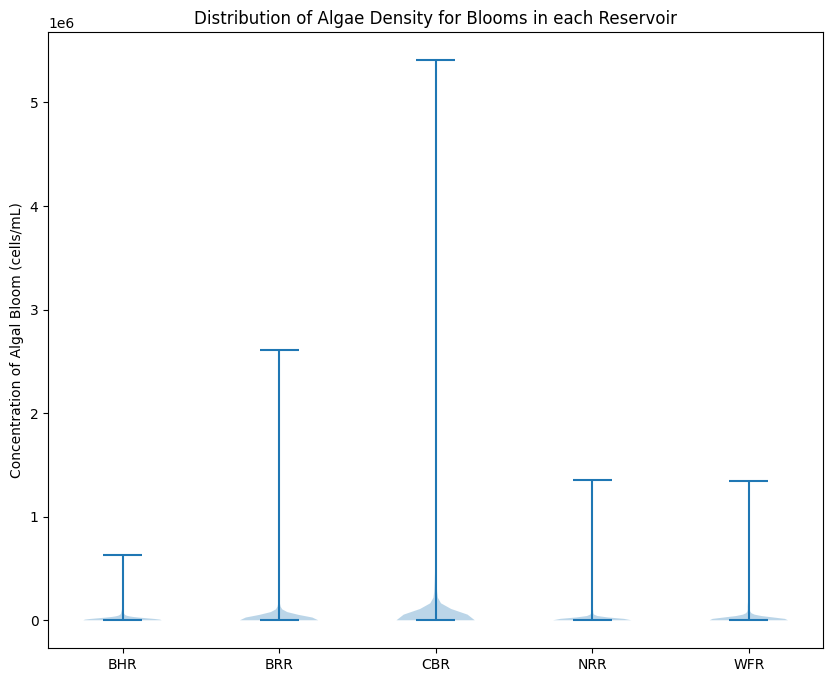

In [937]:
# create violin plots of algae bloom density for 5 reservoirs of interest
pfig, ax = plt.subplots(figsize=(10, 8))
ax.violinplot([algae_bhr['density_cells/ml'], algae_brr['density_cells/ml'], algae_cbr['density_cells/ml'], 
               algae_nrr['density_cells/ml'], algae_wfr['density_cells/ml']])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(['BHR', 'BRR', 'CBR', 'NRR', 'WFR'])
ax.set_ylabel('Concentration of Algal Bloom (cells/mL)')
ax.set_title('Distribution of Algae Density for Blooms in each Reservoir');
plt.savefig('algaeDensityDistribution.png')

In [945]:
reservoir = ['BHR', 'BRR', 'CBR', 'NRR', 'WFR']
mean = [algae_bhr['density_cells/ml'].mean().round(3), algae_brr['density_cells/ml'].mean().round(3), algae_cbr['density_cells/ml'].mean().round(3),
        algae_nrr['density_cells/ml'].mean().round(3), algae_wfr['density_cells/ml'].mean().round(3)]
median = [algae_bhr['density_cells/ml'].median().round(3), algae_brr['density_cells/ml'].median().round(3), algae_cbr['density_cells/ml'].median().round(3),
        algae_nrr['density_cells/ml'].median().round(3), algae_wfr['density_cells/ml'].median().round(3)]
max = [algae_bhr['density_cells/ml'].max().round(3), algae_brr['density_cells/ml'].max().round(3), algae_cbr['density_cells/ml'].max().round(3),
        algae_nrr['density_cells/ml'].max().round(3), algae_wfr['density_cells/ml'].max().round(3)]
min = [algae_bhr['density_cells/ml'].min().round(3), algae_brr['density_cells/ml'].min().round(3), algae_cbr['density_cells/ml'].min().round(3),
        algae_nrr['density_cells/ml'].min().round(3), algae_wfr['density_cells/ml'].min().round(3)]
alg_sum = pd.DataFrame({'reservoir':reservoir, 'average':mean, 'median':median, 'min':min, 'max':max})
alg_sum

,reservoir,average,median,min,max
0,BHR,15715.838,47.771,0.747,628318.750
1,BRR,34852.242,372.450,1.087,2614111.565
2,CBR,68030.684,1076.923,0.385,5406938.572
3,NRR,15059.649,181.616,0.476,1358223.495
4,WFR,20941.917,750.738,6.975,1343110.220


#### Figure 6: Most Common Algae Type

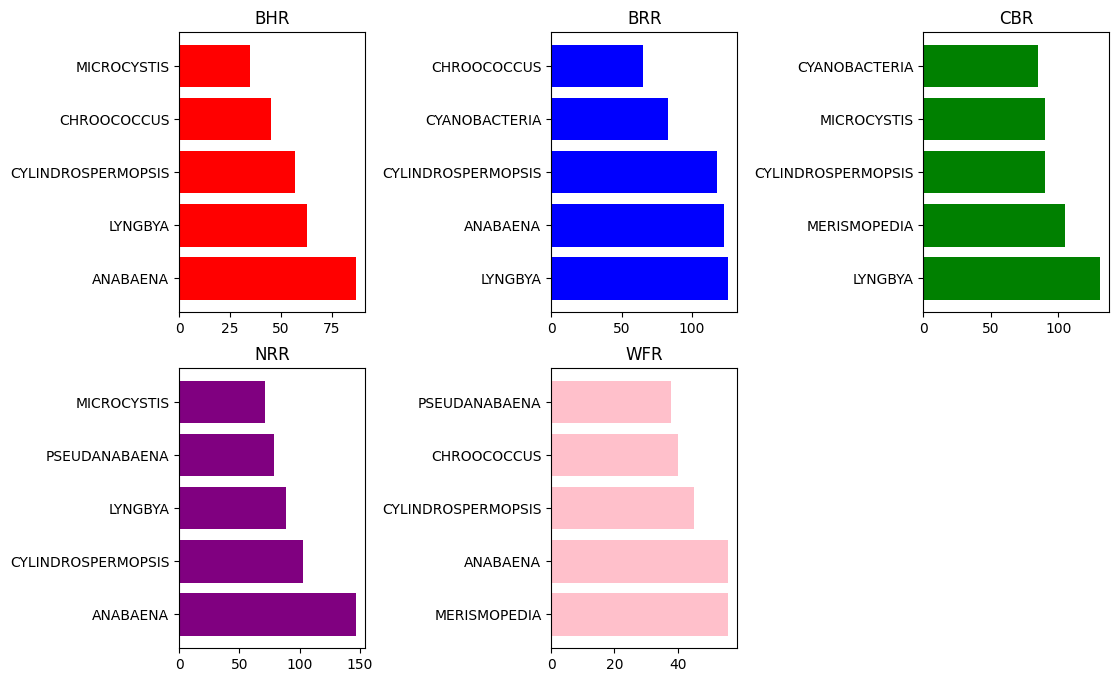

In [948]:
# get the top 5 Algae type for each reservoir
top_bhr = algae_bhr['sci_name'].value_counts().head(5)
top_bhr = pd.DataFrame(top_bhr).reset_index()
top_brr = algae_brr['sci_name'].value_counts().head(5)
top_brr = pd.DataFrame(top_brr).reset_index()
top_cbr = algae_cbr['sci_name'].value_counts().head(5)
top_cbr = pd.DataFrame(top_cbr).reset_index()
top_nrr = algae_nrr['sci_name'].value_counts().head(5)
top_nrr = pd.DataFrame(top_nrr).reset_index()
top_wfr = algae_wfr['sci_name'].value_counts().head(5)
top_wfr = pd.DataFrame(top_wfr).reset_index()

# plot top 5 algae types for each reservoir
fig, ax = plt.subplots(2, 3, gridspec_kw={'wspace': 1}, figsize=(12, 8))
ax[0, 0].barh(top_bhr['sci_name'], top_bhr['count'], color = 'red', label = 'BHR')
ax[0, 0].set_title('BHR')
ax[0, 1].barh(top_brr['sci_name'], top_brr['count'], color = 'blue', label = 'BRR')
ax[0, 1].set_title('BRR')
ax[0, 2].barh(top_cbr['sci_name'], top_cbr['count'], color = 'green', label = 'CBR')
ax[0, 2].set_title('CBR')
ax[1, 0].barh(top_nrr['sci_name'], top_nrr['count'], color = 'purple', label = 'NRR')
ax[1, 0].set_title('NRR')
ax[1, 1].barh(top_wfr['sci_name'], top_wfr['count'], color = 'pink',  label = 'WFR')
ax[1, 1].set_title('WFR')
ax[1, 2].axis('off');
plt.savefig('topAlgaeTypes.png')

#### Figure 7: Average density of an algal bloom over time per reservoir

In [810]:
# calculate average bloom density by year
bhr_y = pd.DataFrame(algae_bhr.groupby('year')['density_cells/ml'].mean()).reset_index()
bhr_y['year'] = bhr_y['year'].astype('int64')
brr_y = pd.DataFrame(algae_brr.groupby('year')['density_cells/ml'].mean()).reset_index()
brr_y['year'] = brr_y['year'].astype('int64')
cbr_y = pd.DataFrame(algae_cbr.groupby('year')['density_cells/ml'].mean()).reset_index()
cbr_y['year'] = cbr_y['year'].astype('int64')
nrr_y = pd.DataFrame(algae_nrr.groupby('year')['density_cells/ml'].mean()).reset_index()
nrr_y['year'] = nrr_y['year'].astype('int64')
wfr_y = pd.DataFrame(algae_wfr.groupby('year')['density_cells/ml'].mean()).reset_index()
wfr_y['year'] = wfr_y['year'].astype('int64')

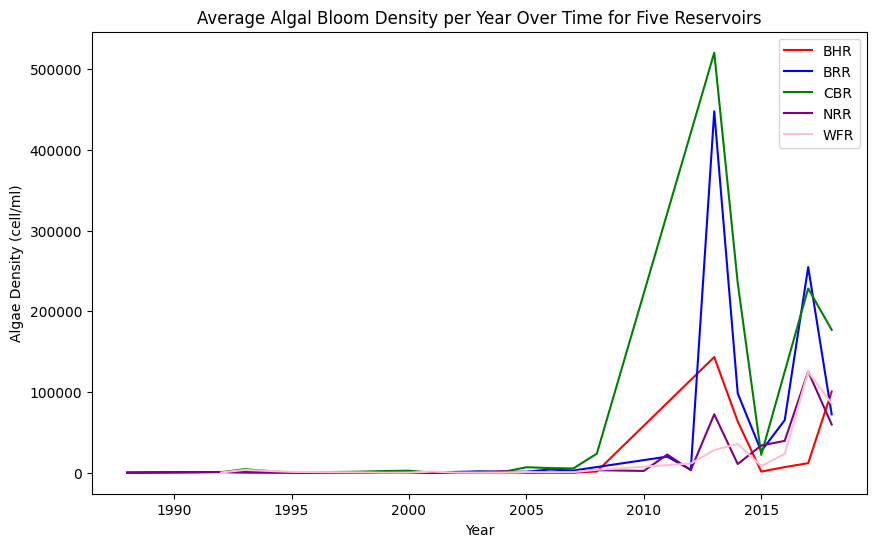

In [949]:
# create line plot for change in temperatures
plt.figure(figsize = (10, 6))
plt.plot(bhr_y['year'], bhr_y['density_cells/ml'], color = 'red', label = 'BHR')
plt.plot(brr_y['year'], brr_y['density_cells/ml'], color = 'blue', label = 'BRR')
plt.plot(cbr_y['year'], cbr_y['density_cells/ml'], color = 'green', label = 'CBR')
plt.plot(nrr_y['year'], nrr_y['density_cells/ml'], color = 'purple', label = 'NRR')
plt.plot(wfr_y['year'], wfr_y['density_cells/ml'], color = 'pink', label = 'WFR')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Algae Density (cell/ml)')
plt.title('Average Algal Bloom Density per Year Over Time for Five Reservoirs');
plt.savefig('avgAlgaeDensity.png')

#### Figure 8: Average Precipitation per year per reservoir

In [844]:
precip = pd.DataFrame(api.groupby(['reservoir', 'year'])['precipitation_sum'].mean()).reset_index()
precip

,reservoir,year,precipitation_sum
0,BHR,1987,2.749589
1,BHR,1988,2.597268
2,BHR,1989,3.878082
3,BHR,1990,3.943014
4,BHR,1991,3.478082
...,...,...,...
170,WFR,2017,3.274795
171,WFR,2018,4.056986
172,WFR,2019,3.176164
173,WFR,2020,3.072404


In [956]:
precip['year'] = precip['year'].astype('int64')
# split avg do by reservoir
avgP_bhr = precip[precip['reservoir'] == 'BHR']
avgP_brr = precip[precip['reservoir'] == 'BRR']
avgP_cbr = precip[precip['reservoir'] == 'CBR']
avgP_nrr = precip[precip['reservoir'] == 'NRR']
avgP_wfr = precip[precip['reservoir'] == 'WFR']

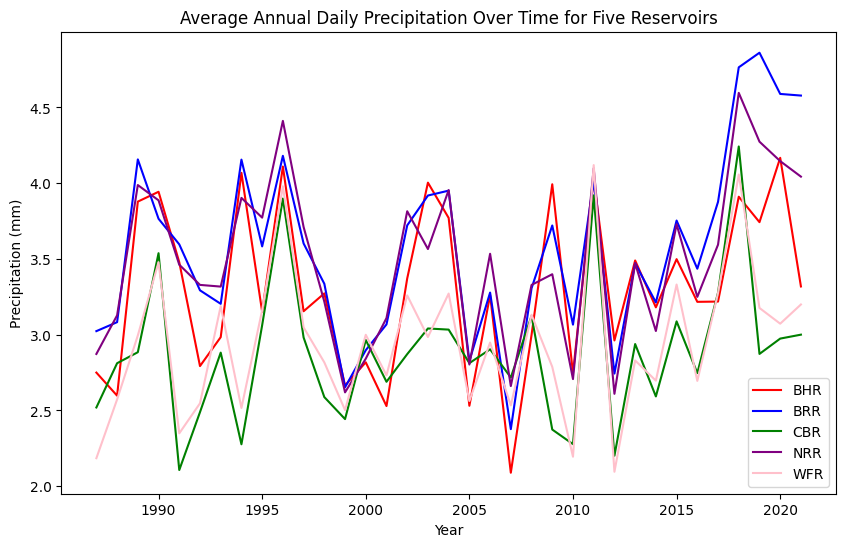

In [957]:
# create line plot for change in do over time
plt.figure(figsize = (10, 6))
plt.plot(avgP_bhr['year'], avgP_bhr['precipitation_sum'], color = 'red', label = 'BHR')
plt.plot(avgP_brr['year'], avgP_brr['precipitation_sum'], color = 'blue', label = 'BRR')
plt.plot(avgP_cbr['year'], avgP_cbr['precipitation_sum'], color = 'green', label = 'CBR')
plt.plot(avgP_nrr['year'], avgP_nrr['precipitation_sum'], color = 'purple', label = 'NRR')
plt.plot(avgP_wfr['year'], avgP_wfr['precipitation_sum'], color = 'pink', label = 'WFR')
plt.legend(loc = "lower right")
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Average Annual Daily Precipitation Over Time for Five Reservoirs');
plt.savefig('avgPrecip.png')

#### Figure 9: Deep Temp vs Dissolved Oxygen

In [964]:
# get average deep temp and average do for each year
dTemp = pd.DataFrame(deepTemp.groupby('year')['temperature'].mean()).reset_index()
avg_do = pd.DataFrame(do.groupby('year')['do'].mean()).reset_index()

In [965]:
# merge dataframes
do_dtemp = pd.merge(dTemp, avg_do, on='year')
do_dtemp.head()

,year,temperature,do
0,1989,15.204561,2.928767
1,1990,15.831694,3.341527
2,1991,14.767932,2.672122
3,1992,15.085625,3.174031
4,1993,14.363387,3.157388


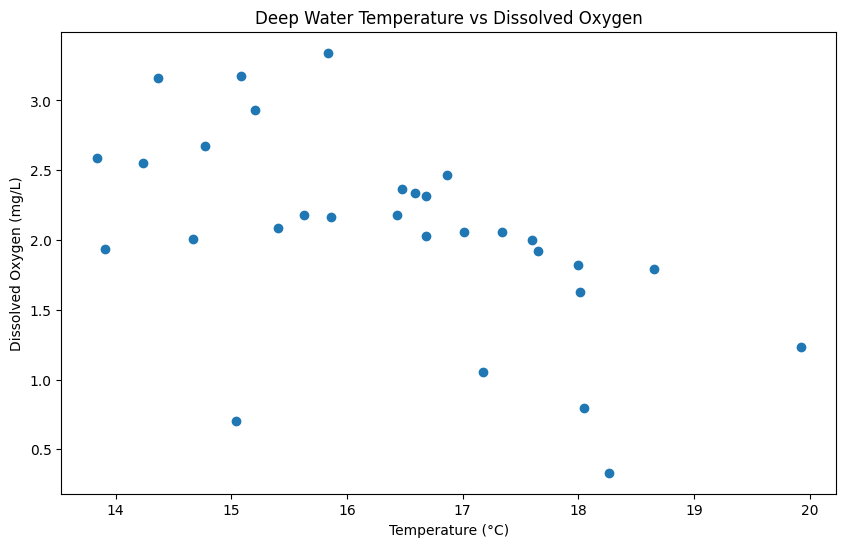

In [966]:
# create scatter plot
plt.figure(figsize = (10, 6))
plt.scatter(do_dtemp['temperature'], do_dtemp['do'])
plt.xlabel('Temperature (°C)')
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.title('Deep Water Temperature vs Dissolved Oxygen');
plt.savefig('deepTemp vs DO.png')

#### Figure 10: Yearly average algae conc vs Dissolved Oxygen

In [967]:
# calculate yearly average algae conc
alg = pd.DataFrame(algae.groupby('year')['density_cells/ml'].mean()).reset_index()
alg.head()

,year,density_cells/ml
0,1987,66.190269
1,1988,224.566250
2,1992,1499.253569
3,1993,2979.579727
4,1995,419.350812


In [968]:
# merge avg_do with alg
alg_do = pd.merge(alg, avg_do, on='year')
alg_do.head()

,year,density_cells/ml,do
0,1992,1499.253569,3.174031
1,1993,2979.579727,3.157388
2,1995,419.350812,2.336533
3,1998,293.680013,1.626027
4,1999,551.005755,2.590632


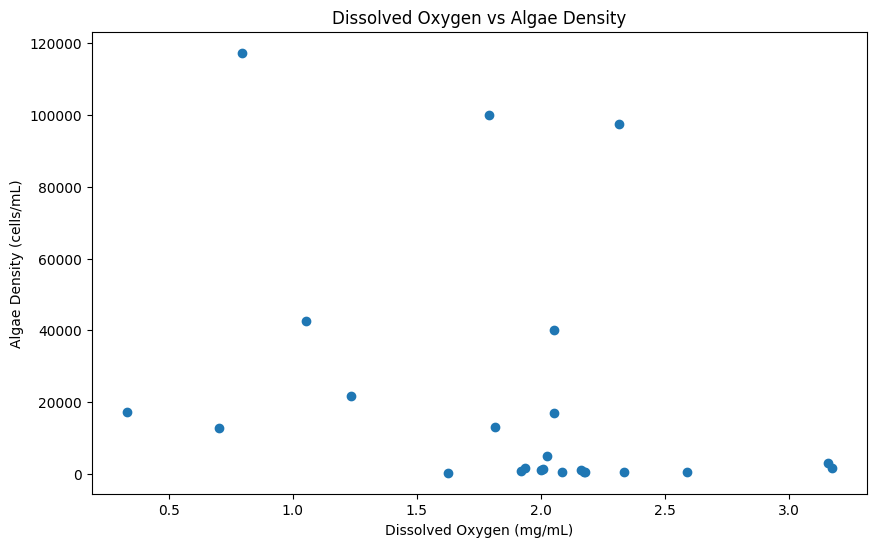

In [969]:
plt.figure(figsize = (10, 6))
plt.scatter(alg_do['do'], alg_do['density_cells/ml'])
plt.xlabel('Dissolved Oxygen (mg/mL)')
plt.ylabel('Algae Density (cells/mL)')
plt.title('Dissolved Oxygen vs Algae Density');
plt.savefig('DO vs AlgaeDens.png')